# Housing Price Prediction

**Problem**: Predict housing price from features such as the amount of bedrooms, area, and stories.

This is a regression problem focused on housing data with an emphasis on feature engineering in the form of creating new features, removing weakly correlated ones, and handling outliers and skewed distributions. I used cross-validation to compare Linear Regression and XGBoost.

In [2]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import make_scorer, r2_score, root_mean_squared_error
from sklearn.linear_model import LinearRegression


#### Describing the data

In [3]:
df = pd.read_csv("./data/Housing.csv") # https://www.kaggle.com/datasets/yasserh/housing-prices-dataset
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished


In [4]:
df.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


#### Data Cleaning

The data types of columns "mainroad", "guestroom", "basement", "hotwaterheating", "airconditioning", "prefarea", and "furnishingstatus" is incompatible.

We change the yes/no to bool and the "furnishingstatus" to one ordinal encoded:

In [5]:
bool_cols = ['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea']
for c in bool_cols:
    df[c] = df[c].map({"yes": 1, "no": 0})

df["furnishingstatus"] = pd.Categorical(
    df["furnishingstatus"],
    categories=["unfurnished", "semi-furnished", "furnished"],
    ordered=True
).codes
df

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,2
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,2
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,2
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,1,0,1,0,0,2,0,0
541,1767150,2400,3,1,1,0,0,0,0,0,0,0,1
542,1750000,3620,2,1,1,1,0,0,0,0,0,0,0
543,1750000,2910,3,1,1,0,0,0,0,0,0,0,2


### Feature Engineering

We start feature engineering by removing features that are not very correlated (I chose a threshold of 0.1) with the label. This reduces noise.

In [6]:
corr = df.corr()["price"]
print(corr.sort_values(ascending=False))


price               1.000000
area                0.535997
bathrooms           0.517545
airconditioning     0.452954
stories             0.420712
parking             0.384394
bedrooms            0.366494
prefarea            0.329777
furnishingstatus    0.304721
mainroad            0.296898
guestroom           0.255517
basement            0.187057
hotwaterheating     0.093073
Name: price, dtype: float64


In [7]:
df.drop("hotwaterheating", axis=1, inplace=True)

The next part is creating new features:

In [8]:
df["rooms"] = df["bedrooms"] + df["bathrooms"] + df["guestroom"]
df["rooms_per_area"] = df["rooms"] / df["area"]
df["bath_bed_ratio"] = df["bathrooms"] / df["bedrooms"]
df['amenities'] = df[["airconditioning", "basement", "parking", "mainroad", "prefarea"]].sum(axis=1).astype(int)
df

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,airconditioning,parking,prefarea,furnishingstatus,rooms,rooms_per_area,bath_bed_ratio,amenities
0,13300000,7420,4,2,3,1,0,0,1,2,1,2,6,0.000809,0.500000,5
1,12250000,8960,4,4,4,1,0,0,1,3,0,2,8,0.000893,1.000000,5
2,12250000,9960,3,2,2,1,0,1,0,2,1,1,5,0.000502,0.666667,5
3,12215000,7500,4,2,2,1,0,1,1,3,1,2,6,0.000800,0.500000,7
4,11410000,7420,4,1,2,1,1,1,1,2,0,2,6,0.000809,0.250000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,1,0,1,0,2,0,0,3,0.001000,0.500000,4
541,1767150,2400,3,1,1,0,0,0,0,0,0,1,4,0.001667,0.333333,0
542,1750000,3620,2,1,1,1,0,0,0,0,0,0,3,0.000829,0.500000,1
543,1750000,2910,3,1,1,0,0,0,0,0,0,2,4,0.001375,0.333333,0


#### Checking skewness of numerical features

In [9]:
numeric_features = ["area", "price", "rooms_per_area"]
df[numeric_features].skew()


area              1.321188
price             1.212239
rooms_per_area    1.377773
dtype: float64

#### Trying to log the skewed features

In [10]:

df["area"] = np.log1p(df["area"])
df["price"] = np.log1p(df["price"])
df["rooms_per_area"] = np.log1p(df["rooms_per_area"])

df[numeric_features].skew()

area              0.133747
price             0.140863
rooms_per_area    1.375680
dtype: float64

That didn't fully work for "rooms_per_area". Let's try to remove outliers from it.

#### Outlier removal

In [11]:
Q1 = df["rooms_per_area"].quantile(0.25)
Q3 = df["rooms_per_area"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df["rooms_per_area"] >= lower_bound) & (df["rooms_per_area"] <= upper_bound)]
df[numeric_features].skew()

area              0.285652
price             0.125385
rooms_per_area    0.430532
dtype: float64

#### Creating train/test split and scaling

In [12]:
X = df.drop("price", axis=1)
y = df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
scaler = StandardScaler()

num_cols = ["price", "area", "rooms_per_area"]

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Cross-Validation and Testing

In [14]:
models = {
    "Linear Regression": LinearRegression(),
    "XGBoost": XGBRegressor()
}

scoring = {
    "r2": make_scorer(r2_score),
    "rmse": make_scorer(root_mean_squared_error, greater_is_better=False)
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [15]:
results = {}

for name, model in models.items():
    cv_results = cross_validate(
        model, X_train, y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=False
    )
    
    results[name] = {
        "R2_mean": np.mean(cv_results["test_r2"]),
        "RMSE_mean": -np.mean(cv_results["test_rmse"]),
        "R2_std": np.std(cv_results["test_r2"]),
        "RMSE_std": np.std(cv_results["test_rmse"])
    }

for name, metrics in results.items():
    print(f"\n{name}")
    print(f"  R²:  {metrics['R2_mean']:.3f} ± {metrics['R2_std']:.3f}")
    print(f"  RMSE: {metrics['RMSE_mean']:.3f} ± {metrics['RMSE_std']:.3f}")


Linear Regression
  R²:  0.667 ± 0.035
  RMSE: 0.205 ± 0.015

XGBoost
  R²:  0.553 ± 0.072
  RMSE: 0.237 ± 0.016


Linear Regression performs better with this problem.

#### Finally testing with test set:

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_og = np.expm1(y_pred)
y_test_og = np.expm1(y_test)

rmse = root_mean_squared_error(y_test_og, y_pred_og)
r2 = r2_score(y_test_og, y_pred_og)
print("RMSE:", rmse)
print("R2:", r2)

RMSE: 1220265.798519977
R2: 0.688795259037086


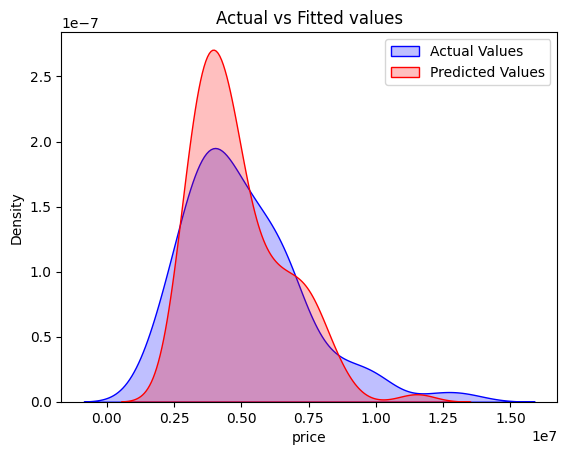

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_dist(y , y_hat):
    plt.figure()
    
    sns.kdeplot(y, color='blue', fill=True, label='Actual Values')
    sns.kdeplot(y_hat, color='red', fill=True, label='Predicted Values')
    plt.legend()
    plt.title('Actual vs Fitted values')
    plt.show()

plot_dist(y_test_og, y_pred_og)

## Recap

In this project, I developed a machine learning model to predict housing prices using features such as location, property size, and number of rooms. I went through the full ML pipeline, including data cleaning, exploratory analysis, feature engineering, and model training. I compared two regression models using standard evaluation metrics and selected the best-performing one. The final model achieved solid predictive accuracy at $R^2 \approx 0.67$.